In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, math, json
from tqdm import tqdm

plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'Fira Code'
plt.rcParams['font.monospace'] = 'Fira Code'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['grid.alpha'] = 0.5

def parse_run_name(run_name):
    run_parts = run_name.split('+')
    assert len(run_parts) == 2
    prompt = run_parts[0]
    loss_info = run_parts[1]
    learning_rate = loss_info.split('_')[-1]
    loss_type = loss_info[:-len(learning_rate)-1]
    if "-" in loss_type:
        loss_name, huber_delta = loss_type.split("-")
    else:
        loss_name = loss_type
        huber_delta = 1

    return {
        "prompt": prompt,
        "loss_type": loss_name,
        "huber_delta": huber_delta,
        "learning_rate": float(learning_rate),
    }

parse_run_name('maxwell the cat+l2_5e-06')
parse_run_name('a picture of a drake+huber_scheduled_backwards-0.001_7e-06')

{'prompt': 'a picture of a drake',
 'loss_type': 'huber_scheduled_backwards',
 'huber_delta': '0.001',
 'learning_rate': 7e-06}

In [220]:
def parse_filename(filename):

    filename = filename.strip('.json')
    
    model_type = ""

    if filename.startswith('bare'):
        model_type = "bare"
        poison_type = "bare"
        step = 0
        poison_fraction = 0
    elif filename.startswith('clean'):
        model_type = "clean"
        poison_type = "clean"
    elif filename.startswith('poison'):
        model_type = "poison"
    
    filename = filename[len(model_type) + 1:]

    compares_with = ""

    if filename.startswith('to_clea'):
        filename = filename[len('to_clean'):]
        compares_with = "clean_pictures"
    elif filename.startswith('to_poison'):
        filename = filename[len('to_poison'):]
        compares_with = "poison"
    
    if compares_with == "clean_pictures":

        filename_parts = filename.split('_')
        step_percentage_candidate = filename_parts[-1]

        try:
            poison_fraction = int(step_percentage_candidate)
            step = -1
        except Exception as e:
            step = 0 # case for bare model
            try:
                poison_fraction = float(step_percentage_candidate)
            except Exception as f:
                poison_fraction = 0
        
        if step != 0:
            step_candidate = filename_parts[-1]
            percentage_candidate = filename_parts[-2]

            try:
                poison_fraction = float(percentage_candidate)
                step = int(step_candidate)
                filename = filename.strip(step_candidate).strip('_')
                filename = filename.strip(percentage_candidate).strip('_')
            except Exception as e:
                step = int(step_candidate)
                filename = filename.strip(step_candidate).strip('_')

    elif compares_with == "poison" and not model_type == "bare":
        filename_parts = filename.split('_')
        step_percentage_candidate = filename_parts[-1]

        step_candidate = filename_parts[-1]
        percentage_candidate = filename_parts[-2]

        try:
            poison_fraction = float(percentage_candidate)
            step = int(step_candidate)
            filename = filename.strip(step_candidate).strip('_')
            filename = filename.strip(percentage_candidate).strip('_')
        except Exception as e:
            poison_fraction = int(step_candidate)
            step = 0
            filename = filename.strip(step_candidate).strip('_')

    if model_type != "bare":
        poison_type = ""

        if filename.endswith('clip-unsimilar'):
            poison_type = "clip-unsimilar"
        elif filename.startswith('clip-similar'):
            poison_type = "clip-similar"
        elif filename.endswith('random'):
            poison_type = "random"

    return {
        'step': step, # 0 if bare
        'model_type': model_type,
        'model_poison_type': poison_type, # clean or clip-unsimilar, etc
        'model_poison_fraction': poison_fraction, # 0 if clear model
        'compares_with': compares_with # clean data, poison name
    }

parse_filename('bare_to_poison_a picture of a drake_clip-unsimilar_0.15.json')
parse_filename('poison_to_poison_a picture by david revoy_clip-unsimilar_0.15_001000.json')
parse_filename('poison_to_clean_maxwell the cat_clip-unsimilar_0.3_000500.json')

{'step': 500,
 'model_type': 'poison',
 'model_poison_type': 'clip-unsimilar',
 'model_poison_fraction': 0.3,
 'compares_with': 'clean_pictures'}

In [221]:
def read_stats(filename, x_type='CLIP Sim'):
    with open(filename, 'r', encoding='utf-8') as f:
        content = json.loads(f.read())
    clipsim_info = content[x_type]

    table = []
    for _, v in clipsim_info['runs'].items():
        t = []
        for v_inner in v:
            t.append(v_inner['score'])
        table.append(t)
    np_table = np.array(table).T
    value = np_table.min(axis=0).min()
    
    return {
        "mean": clipsim_info['mean'],
        "std": clipsim_info['std'],
        "min": clipsim_info['min'],
        "max": clipsim_info['max'],
        "max min sim": value
    }

In [222]:
rs = {}

In [223]:
poisons = {}
poisons_at_prompts = {}
poisons_sims_to_clean = {}
poisons_sims_to_poison = {}

In [206]:
# STEP \ CLIPSIMs:  L2, huber-0.001, huber-scheduled-0.001

prompt = "maxwell the cat"
#prompt = "a picture by david revoy"
#prompt = "a picture of a drake"
#prompt = "a landscape of sks"
#prompt = "a photo of a shoan"
#prompt = "a photo of an eichpoch"
#prompt = "a picture in the style of lordbob"
model_poison_type = "clip-unsimilar"
poison_amount = "0.45"
huber_delta = "0.1"

x_type = "1 - LPIPS"
target = "mean"

max_step = 2001
step_size = 500

data_to_clean = {k: {} for k in range(0, max_step, step_size)} # step: info
data_to_poison = {k: {} for k in range(0, max_step, step_size)}
clean_to_clean = {k: {} for k in range(0, max_step, step_size)} # step: info
clean_to_poison = {k: {} for k in range(0, max_step, step_size)}
data_r = {k: {} for k in range(0, max_step, step_size)}
clean_r = {k: {} for k in range(0, max_step, step_size)}
delta_r = {k: {} for k in range(0, max_step, step_size)}
#stats_folder = "3k-0.001/stats_fixed/"picture of a drake
#stats_folder = "stats-fixedhuber"
#stats_folder = "stats"
stats_folder = "stats_mixed"

for poison_amount in ["X", poison_amount]:

    for folder in os.listdir(stats_folder):
        if prompt in folder and (huber_delta in folder or "l2" in folder):
            run_info = parse_run_name(folder)
            loss_type = run_info['loss_type']
            if "l2" not in loss_type:
                loss_type += '-' + run_info['huber_delta']

            for file in os.listdir(os.path.join(stats_folder, folder)):
                file_info = parse_filename(file)
                stats = read_stats(os.path.join(stats_folder, folder, file), x_type)
                value = stats[target]

                step = file_info['step']
                if step > max_step or step % step_size != 0:
                    continue
                
                if file_info['compares_with'] == "clean_pictures" and (poison_amount in file or file_info['model_poison_type'] == "bare" or poison_amount == "X" and file_info['model_type'] == "clean"):
                    if poison_amount == "X":
                        clean_to_clean[step][loss_type] = value
                    else:
                        data_to_clean[step][loss_type] = value
                elif (file_info['model_poison_type'] == model_poison_type and poison_amount in file or poison_amount == "X" and "0.45" in file and file_info['model_type'] == "clean") or (file_info['model_poison_type'] == "bare" and file_info['compares_with'] == "poison"):
                    if poison_amount == "X":
                        clean_to_poison[step][loss_type] = value
                    else:
                        data_to_poison[step][loss_type] = value


for k in range(0, max_step, step_size):
    for key, value in data_to_clean[k].items():
        data_r[k][key] = data_to_clean[k][key]# - data_to_poison[k][key]
    for key, value in data_to_clean[k].items():
        clean_r[k][key] = clean_to_clean[k][key]# - clean_to_poison[k][key]
    for key, value in data_to_clean[k].items():
        delta_r[k][key] = data_r[k][key] - clean_r[k][key] # - clean_to_poison[k][key]

# (data_to_clean - clean_to_clean) - (data_to_poison - clean_to_poison)

#for k in range(0, max_step, step_size):
#     for key, value in data_to_clean[k].items():
#         data_to_clean[k][key] = value - clean_to_clean[k][key]
#     for key, value in data_to_poison[k].items():
#          
rs[prompt] = delta_r
poisons[poison_amount] = delta_r
if poison_amount not in poisons_at_prompts:
    poisons_at_prompts[poison_amount] = {}
poisons_at_prompts[poison_amount][prompt] = delta_r

poisons_sims_to_clean[poison_amount] = data_to_clean
poisons_sims_to_poison[poison_amount] = data_to_poison

ctc = pd.DataFrame([{'step':k, **v} for k,v in clean_to_clean.items()])
ctp = pd.DataFrame([{'step':k, **v} for k,v in clean_to_poison.items()])
dtc = pd.DataFrame([{'step':k, **v} for k,v in data_to_clean.items()])
dtp = pd.DataFrame([{'step':k, **v} for k,v in data_to_poison.items()])
r_data = pd.DataFrame([{'step':k, **v} for k,v in data_r.items()])
r_clean = pd.DataFrame([{'step':k, **v} for k,v in clean_r.items()])
r_delta = pd.DataFrame([{'step':k, **v} for k,v in delta_r.items()])

In [266]:
# AUTOMATED TOTAL SWEEP

rs = {}
poisons_at_prompts = {}
similarity_to_cleans_at_prompts = {}
similarity_to_poisons_at_prompts = {}

model_poison_type = "clip-unsimilar"
poison_amounts = ["0.15", "0.3", "0.45"]
huber_delta = "0.1"

x_type = "1 - LPIPS"
target = "mean"

prompts = ["maxwell the cat", "a picture by david revoy", "a picture of a drake", "a landscape of sks", "a photo of a shoan", "a photo of an eichpoch", "a picture in the style of lordbob"]

max_step = 2001
step_size = 500

old = False#True

for poison_amt in poison_amounts:
    for prompt in prompts:

        data_to_clean = {k: {} for k in range(0, max_step, step_size)} # step: info
        data_to_poison = {k: {} for k in range(0, max_step, step_size)}
        clean_to_clean = {k: {} for k in range(0, max_step, step_size)} # step: info
        clean_to_poison = {k: {} for k in range(0, max_step, step_size)}
        data_r = {k: {} for k in range(0, max_step, step_size)}
        clean_r = {k: {} for k in range(0, max_step, step_size)}
        poison_r = {k: {} for k in range(0, max_step, step_size)}
        delta_r = {k: {} for k in range(0, max_step, step_size)}

        for poison_amount in ["X", poison_amt]:

            for folder in os.listdir(stats_folder):

                if not old and ("old" in folder or "backward" in folder):
                    #print(folder)
                    continue

                if prompt in folder and (huber_delta in folder or "l2" in folder):
                    run_info = parse_run_name(folder)
                    loss_type = run_info['loss_type']
                    if "l2" not in loss_type:
                        loss_type += '-' + run_info['huber_delta']

                    for file in os.listdir(os.path.join(stats_folder, folder)):

                        file_info = parse_filename(file)
                        stats = read_stats(os.path.join(stats_folder, folder, file), x_type)
                        value = stats[target]

                        step = file_info['step']
                        if step > max_step or step % step_size != 0:
                            continue
                        
                        if file_info['compares_with'] == "clean_pictures" and (poison_amount in file or file_info['model_poison_type'] == "bare" or poison_amount == "X" and file_info['model_type'] == "clean"):
                            if poison_amount == "X":
                                clean_to_clean[step][loss_type] = value
                            else:
                                data_to_clean[step][loss_type] = value
                        elif (file_info['model_poison_type'] == model_poison_type and poison_amount in file or poison_amount == "X" and "0.45" in file and file_info['model_type'] == "clean") or (file_info['model_poison_type'] == "bare" and file_info['compares_with'] == "poison"):
                            if poison_amount == "X":
                                clean_to_poison[step][loss_type] = value
                            else:
                                data_to_poison[step][loss_type] = value

        for k in range(0, max_step, step_size):
            for key, value in data_to_clean[k].items():
                data_r[k][key] = data_to_clean[k][key]
            for key, value in data_to_clean[k].items():
                clean_r[k][key] = clean_to_clean[k][key]
            for key, value in data_to_clean[k].items():
                poison_r[k][key] = data_to_poison[k][key]
            for key, value in data_to_clean[k].items():
                delta_r[k][key] = data_r[k][key] - clean_r[k][key]

        if poison_amt not in poisons_at_prompts:
            poisons_at_prompts[poison_amt] = {}
        poisons_at_prompts[poison_amt][prompt] = delta_r

        if poison_amt not in similarity_to_cleans_at_prompts:
            similarity_to_cleans_at_prompts[poison_amt] = {}
        similarity_to_cleans_at_prompts[poison_amt][prompt] = data_r

        if poison_amt not in similarity_to_poisons_at_prompts:
            similarity_to_poisons_at_prompts[poison_amt] = {}
        similarity_to_poisons_at_prompts[poison_amt][prompt] = poison_r

In [267]:
poisons_at_prompts

{'0.15': {'maxwell the cat': {0: {'huber-0.1': 0.0,
    'l2': 0.0,
    'huber_scheduled-0.1': 0.0},
   500: {'huber-0.1': -0.0015742273794280143,
    'l2': -0.0009003265036476998,
    'huber_scheduled-0.1': 5.3334153360798386e-05},
   1000: {'huber-0.1': -0.006586483369270965,
    'l2': -0.00819676141772005,
    'huber_scheduled-0.1': 0.0020576976239681244},
   1500: {'huber-0.1': -0.010215535966886416,
    'l2': -0.012934783473610878,
    'huber_scheduled-0.1': -0.0019817716545528913},
   2000: {'huber-0.1': -0.016885100553433105,
    'l2': -0.017658580715457603,
    'huber_scheduled-0.1': -0.006165399319595755}},
  'a picture by david revoy': {0: {'l2': 0.0,
    'huber-0.1': 0.0,
    'huber_scheduled-0.1': 0.0},
   500: {'l2': 0.0007998900232361744,
    'huber-0.1': -0.00030933729573791313,
    'huber_scheduled-0.1': -0.0010849271042674274},
   1000: {'l2': -0.00024097405520140391,
    'huber-0.1': -0.0014108951915712958,
    'huber_scheduled-0.1': 3.5974105783542765e-05},
   1500: {

In [273]:
# make poisons delta_r average
averaged_poison_stats_map = {}
delta = 0.1

tpy = [f"huber-{delta}", f"huber_scheduled-{delta}", "l2"]
#tpy = [f"huber-{delta}", f"huber_old-{delta}", f"huber_scheduled-{delta}", f"huber_scheduled_old-{delta}", f"huber_scheduled_backwards-{delta}", f"huber_scheduled_backwards_old-{delta}", "l2"]

for t in tpy:
    #print(t)
    for amt, info in similarity_to_cleans_at_prompts.items():#similarity_to_cleans_at_prompts.items():#poisons_at_prompts.items():
        #print(amt)
        selected_info = {}

        for prmpt, sts in info.items():
            flag = False
            for k, v in sts.items():
                if t not in v:
                    flag = True
                    break
            if flag:
                continue
            selected_info[prmpt] = {k:v[t] for k, v in sts.items()}
        #print(selected_info)
        df = pd.DataFrame(selected_info)
        #display(df)
        #print(f'mean:')
        mean_df = df.mean(axis=1)
        #display(mean_df)

        if amt not in averaged_poison_stats_map:
            averaged_poison_stats_map[amt] = {}

        if t not in averaged_poison_stats_map:
            averaged_poison_stats_map[amt][t] = {}
        averaged_poison_stats_map[amt][t] = {k: v for k, v in mean_df.items()}
    
print('AVG')
print(averaged_poison_stats_map)

pd.DataFrame(averaged_poison_stats_map['0.15'])

AVG
{'0.15': {'huber-0.1': {0: 0.0, 500: -0.0007703913229645452, 1000: -0.0009130381279034547, 1500: -0.002756705504679487, 2000: -0.0029036572128256044}, 'huber_scheduled-0.1': {0: 0.0, 500: -0.0006717409505521906, 1000: 0.0002593422800747726, 1500: 0.0002857192808172581, 2000: -0.0006806138160279382}, 'l2': {0: 0.0, 500: -0.00040774613681460577, 1000: -0.0010240316121420737, 1500: -0.002473633026271141, 2000: -0.0033202499466018637}}, '0.3': {'huber-0.1': {0: 0.0, 500: -0.0014781673159711148, 1000: -0.0032216078360903233, 1500: -0.005801188838637732, 2000: -0.006859000849978431}, 'huber_scheduled-0.1': {0: 0.0, 500: -0.0003140262902882151, 1000: -1.4686635256159049e-07, 1500: 0.0002497831865602528, 2000: -0.0014000421179498485}, 'l2': {0: 0.0, 500: -0.0008402803382313624, 1000: -0.002485497535513339, 1500: -0.0049553785822680375, 2000: -0.0054067554291473375}}, '0.45': {'huber-0.1': {0: 0.0, 500: -0.0020002056428002585, 1000: -0.003391186802375827, 1500: -0.005807659861455164, 2000: 

,huber-0.1,huber_scheduled-0.1,l2
0,0.000000,0.000000,0.000000
500,-0.000770,-0.000672,-0.000408
1000,-0.000913,0.000259,-0.001024
1500,-0.002757,0.000286,-0.002474
2000,-0.002904,-0.000681,-0.003320


In [274]:
delta_avg_poison_map = {}

In [275]:
delta_avg_poison_map['0.01'] = averaged_poison_stats_map

In [276]:
delta_avg_poison_map

{'0.01': {'0.15': {'huber-0.1': {0: 0.0,
    500: -0.0007703913229645452,
    1000: -0.0009130381279034547,
    1500: -0.002756705504679487,
    2000: -0.0029036572128256044},
   'huber_scheduled-0.1': {0: 0.0,
    500: -0.0006717409505521906,
    1000: 0.0002593422800747726,
    1500: 0.0002857192808172581,
    2000: -0.0006806138160279382},
   'l2': {0: 0.0,
    500: -0.00040774613681460577,
    1000: -0.0010240316121420737,
    1500: -0.002473633026271141,
    2000: -0.0033202499466018637}},
  '0.3': {'huber-0.1': {0: 0.0,
    500: -0.0014781673159711148,
    1000: -0.0032216078360903233,
    1500: -0.005801188838637732,
    2000: -0.006859000849978431},
   'huber_scheduled-0.1': {0: 0.0,
    500: -0.0003140262902882151,
    1000: -1.4686635256159049e-07,
    1500: 0.0002497831865602528,
    2000: -0.0014000421179498485},
   'l2': {0: 0.0,
    500: -0.0008402803382313624,
    1000: -0.002485497535513339,
    1500: -0.0049553785822680375,
    2000: -0.0054067554291473375}},
  '0.45':

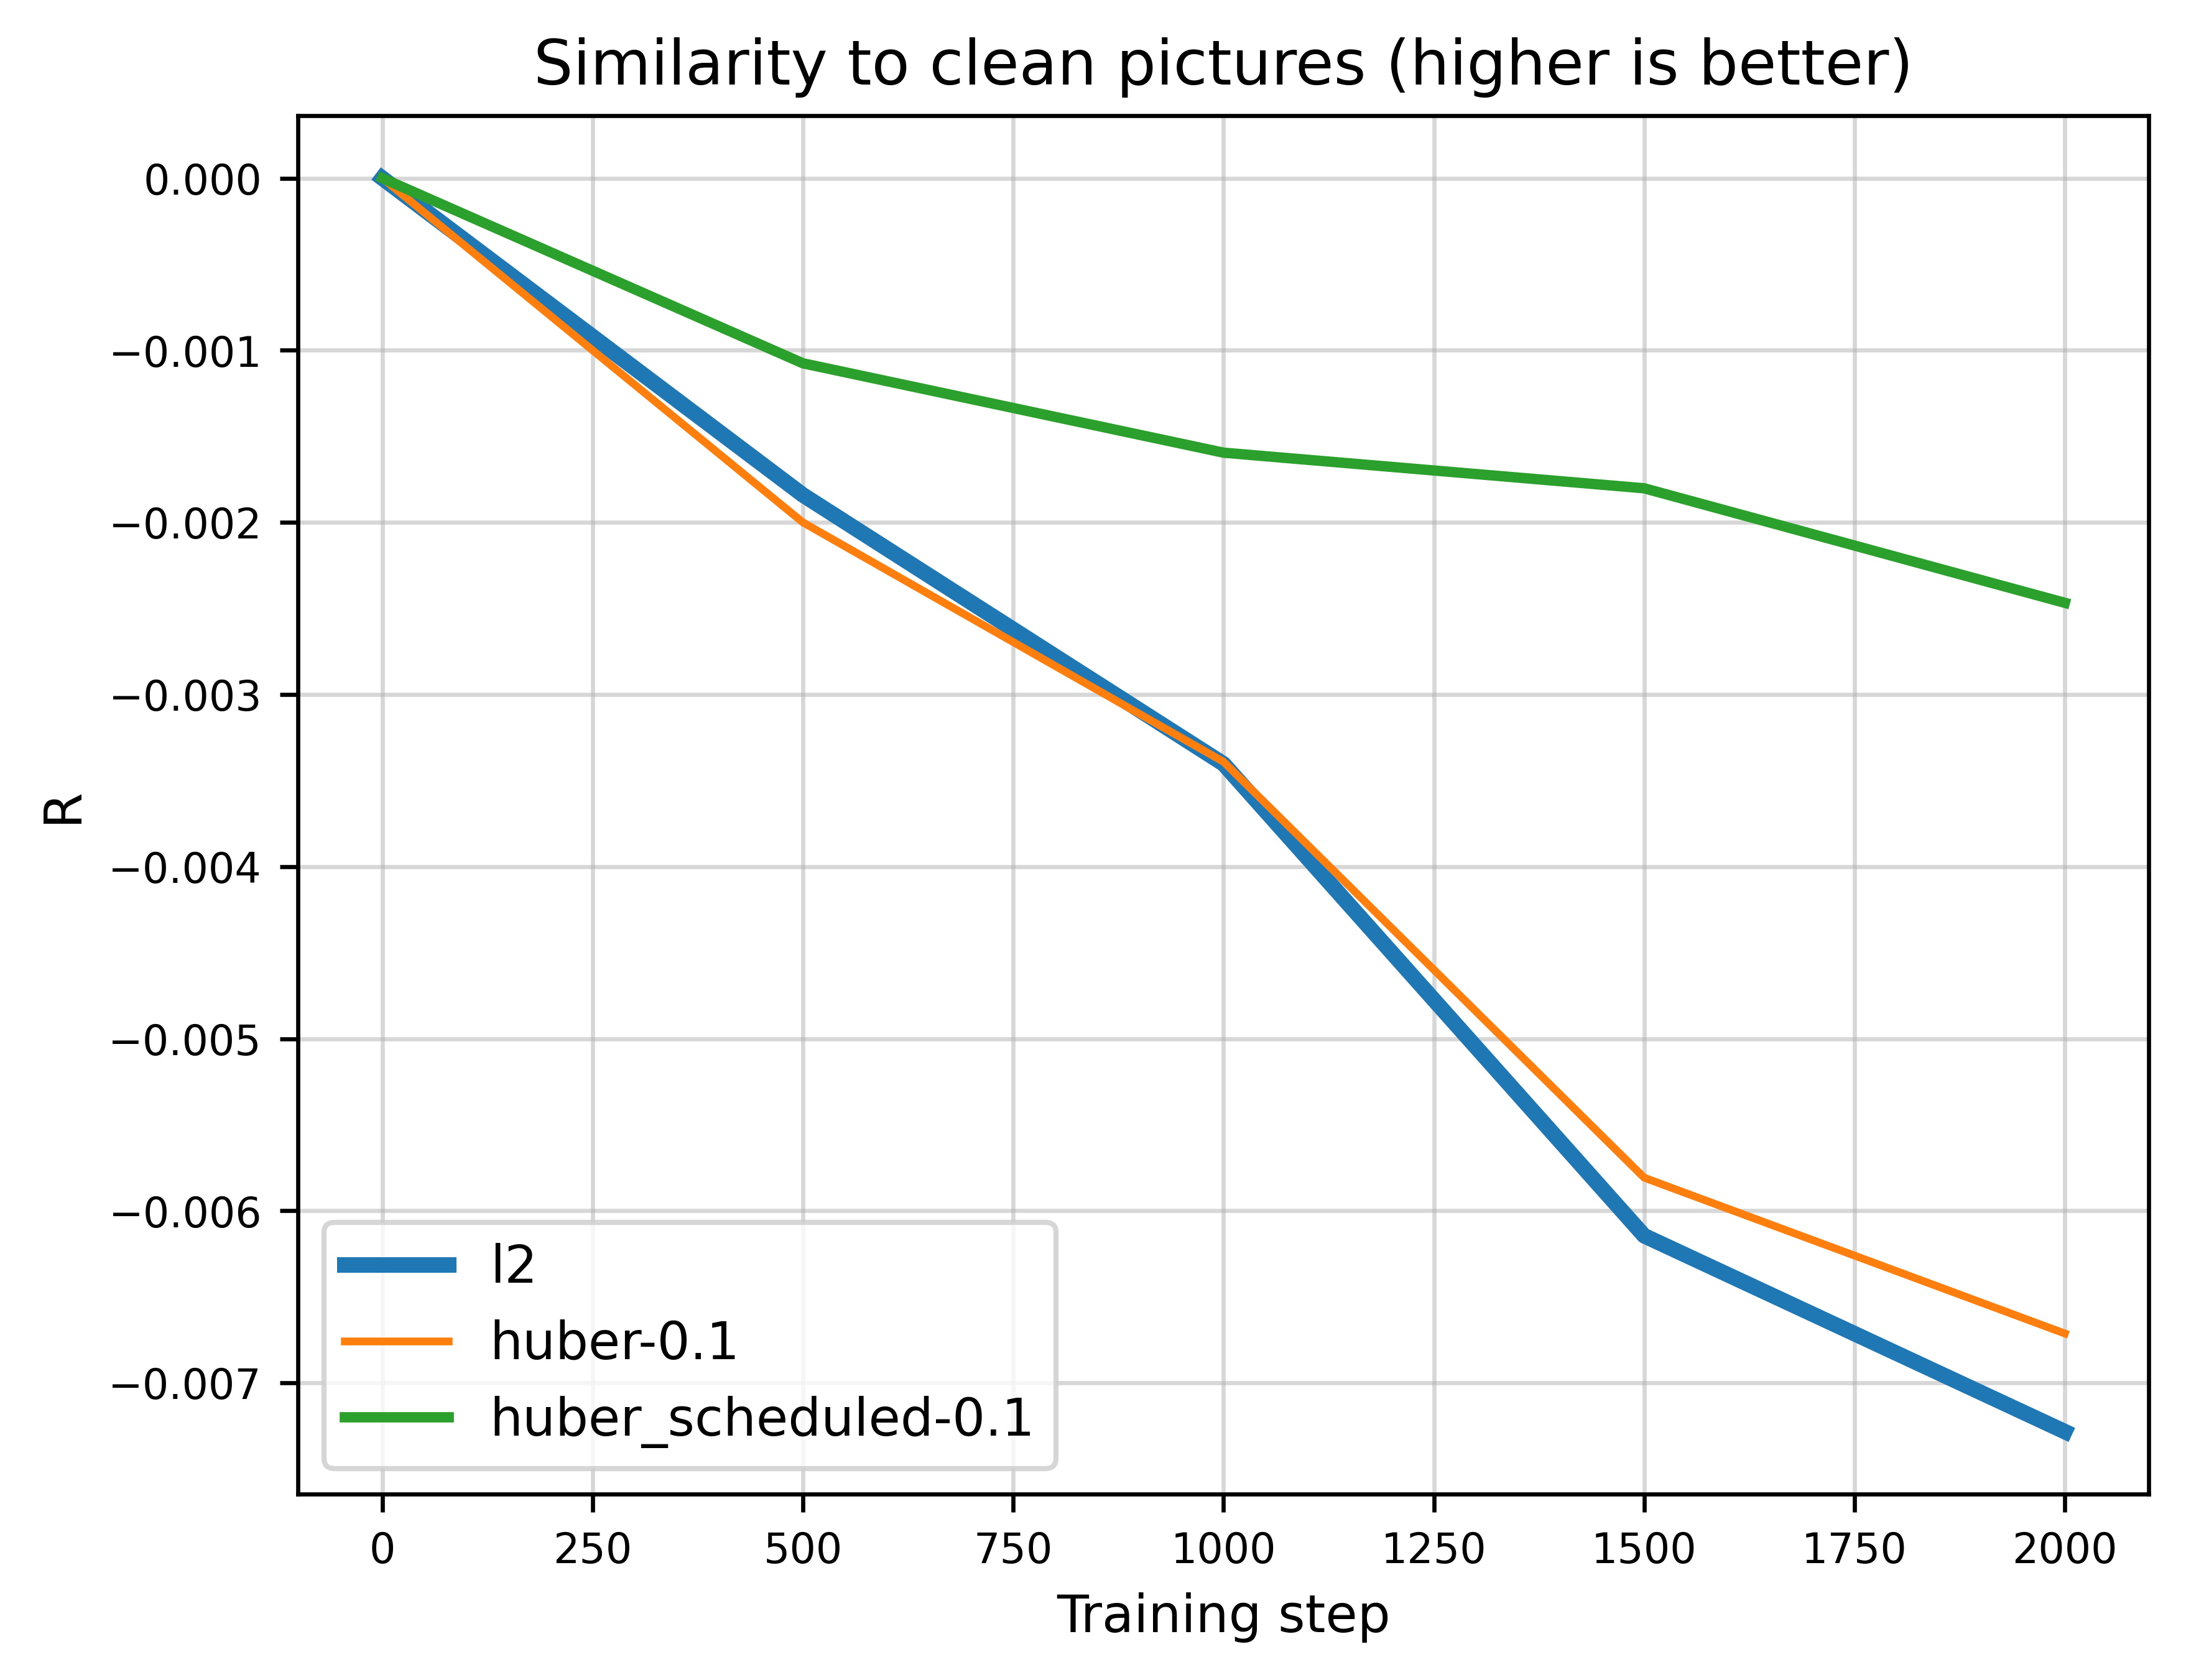

In [277]:
# now plot the table in matplotlib

my_poison = '0.45'

my_df = pd.DataFrame(averaged_poison_stats_map[my_poison])
my_df.index.names = ['step']
my_df = my_df.reset_index()
huber_delta = "0.1"

# Delta R (resilience) AVERAGED

fig = plt.figure(dpi=600)
ax = plt.subplot(111)
ax.set_xlabel('Training step')
ax.set_ylabel('R')
ax.set_title(f'Similarity to clean pictures (higher is better)')# comparison: {float(my_poison):.0%} corruption')#('Delta Resilience (higher is better)')
#ax.set_xlim([0, 5000])
ax.grid('on')

plt.plot(my_df["step"], my_df["l2"], label="l2", linewidth=3)
plt.plot(my_df["step"], my_df[f"huber-{huber_delta}"], label=f"huber-{huber_delta}")
plt.plot(my_df["step"], my_df[f"huber_scheduled-{huber_delta}"], label=f"huber_scheduled-{huber_delta}", linewidth=2)
#plt.plot(my_df["step"], my_df[f"huber_scheduled_backwards-{huber_delta}"], label=f"huber_scheduled_backwards-{huber_delta}", linewidth=2)
#plt.plot(my_df["step"], my_df[f"huber_old-{huber_delta}"], label=f"huber_old-{huber_delta}")
#plt.plot(my_df["step"], my_df[f"huber_scheduled_old-{huber_delta}"], label=f"huber_scheduled_old-{huber_delta}", linewidth=2)
#plt.plot(my_df["step"], my_df[f"huber_scheduled_backwards_old-{huber_delta}"], label=f"huber_scheduled_backwards_old-{huber_delta}", linewidth=2)

plt.legend(loc="lower left")
plt.savefig(f"plots/{prompt}+{huber_delta}+{poison_amount}+{model_poison_type}={x_type}={target}=delta-resilience-averaged.png")
plt.show()

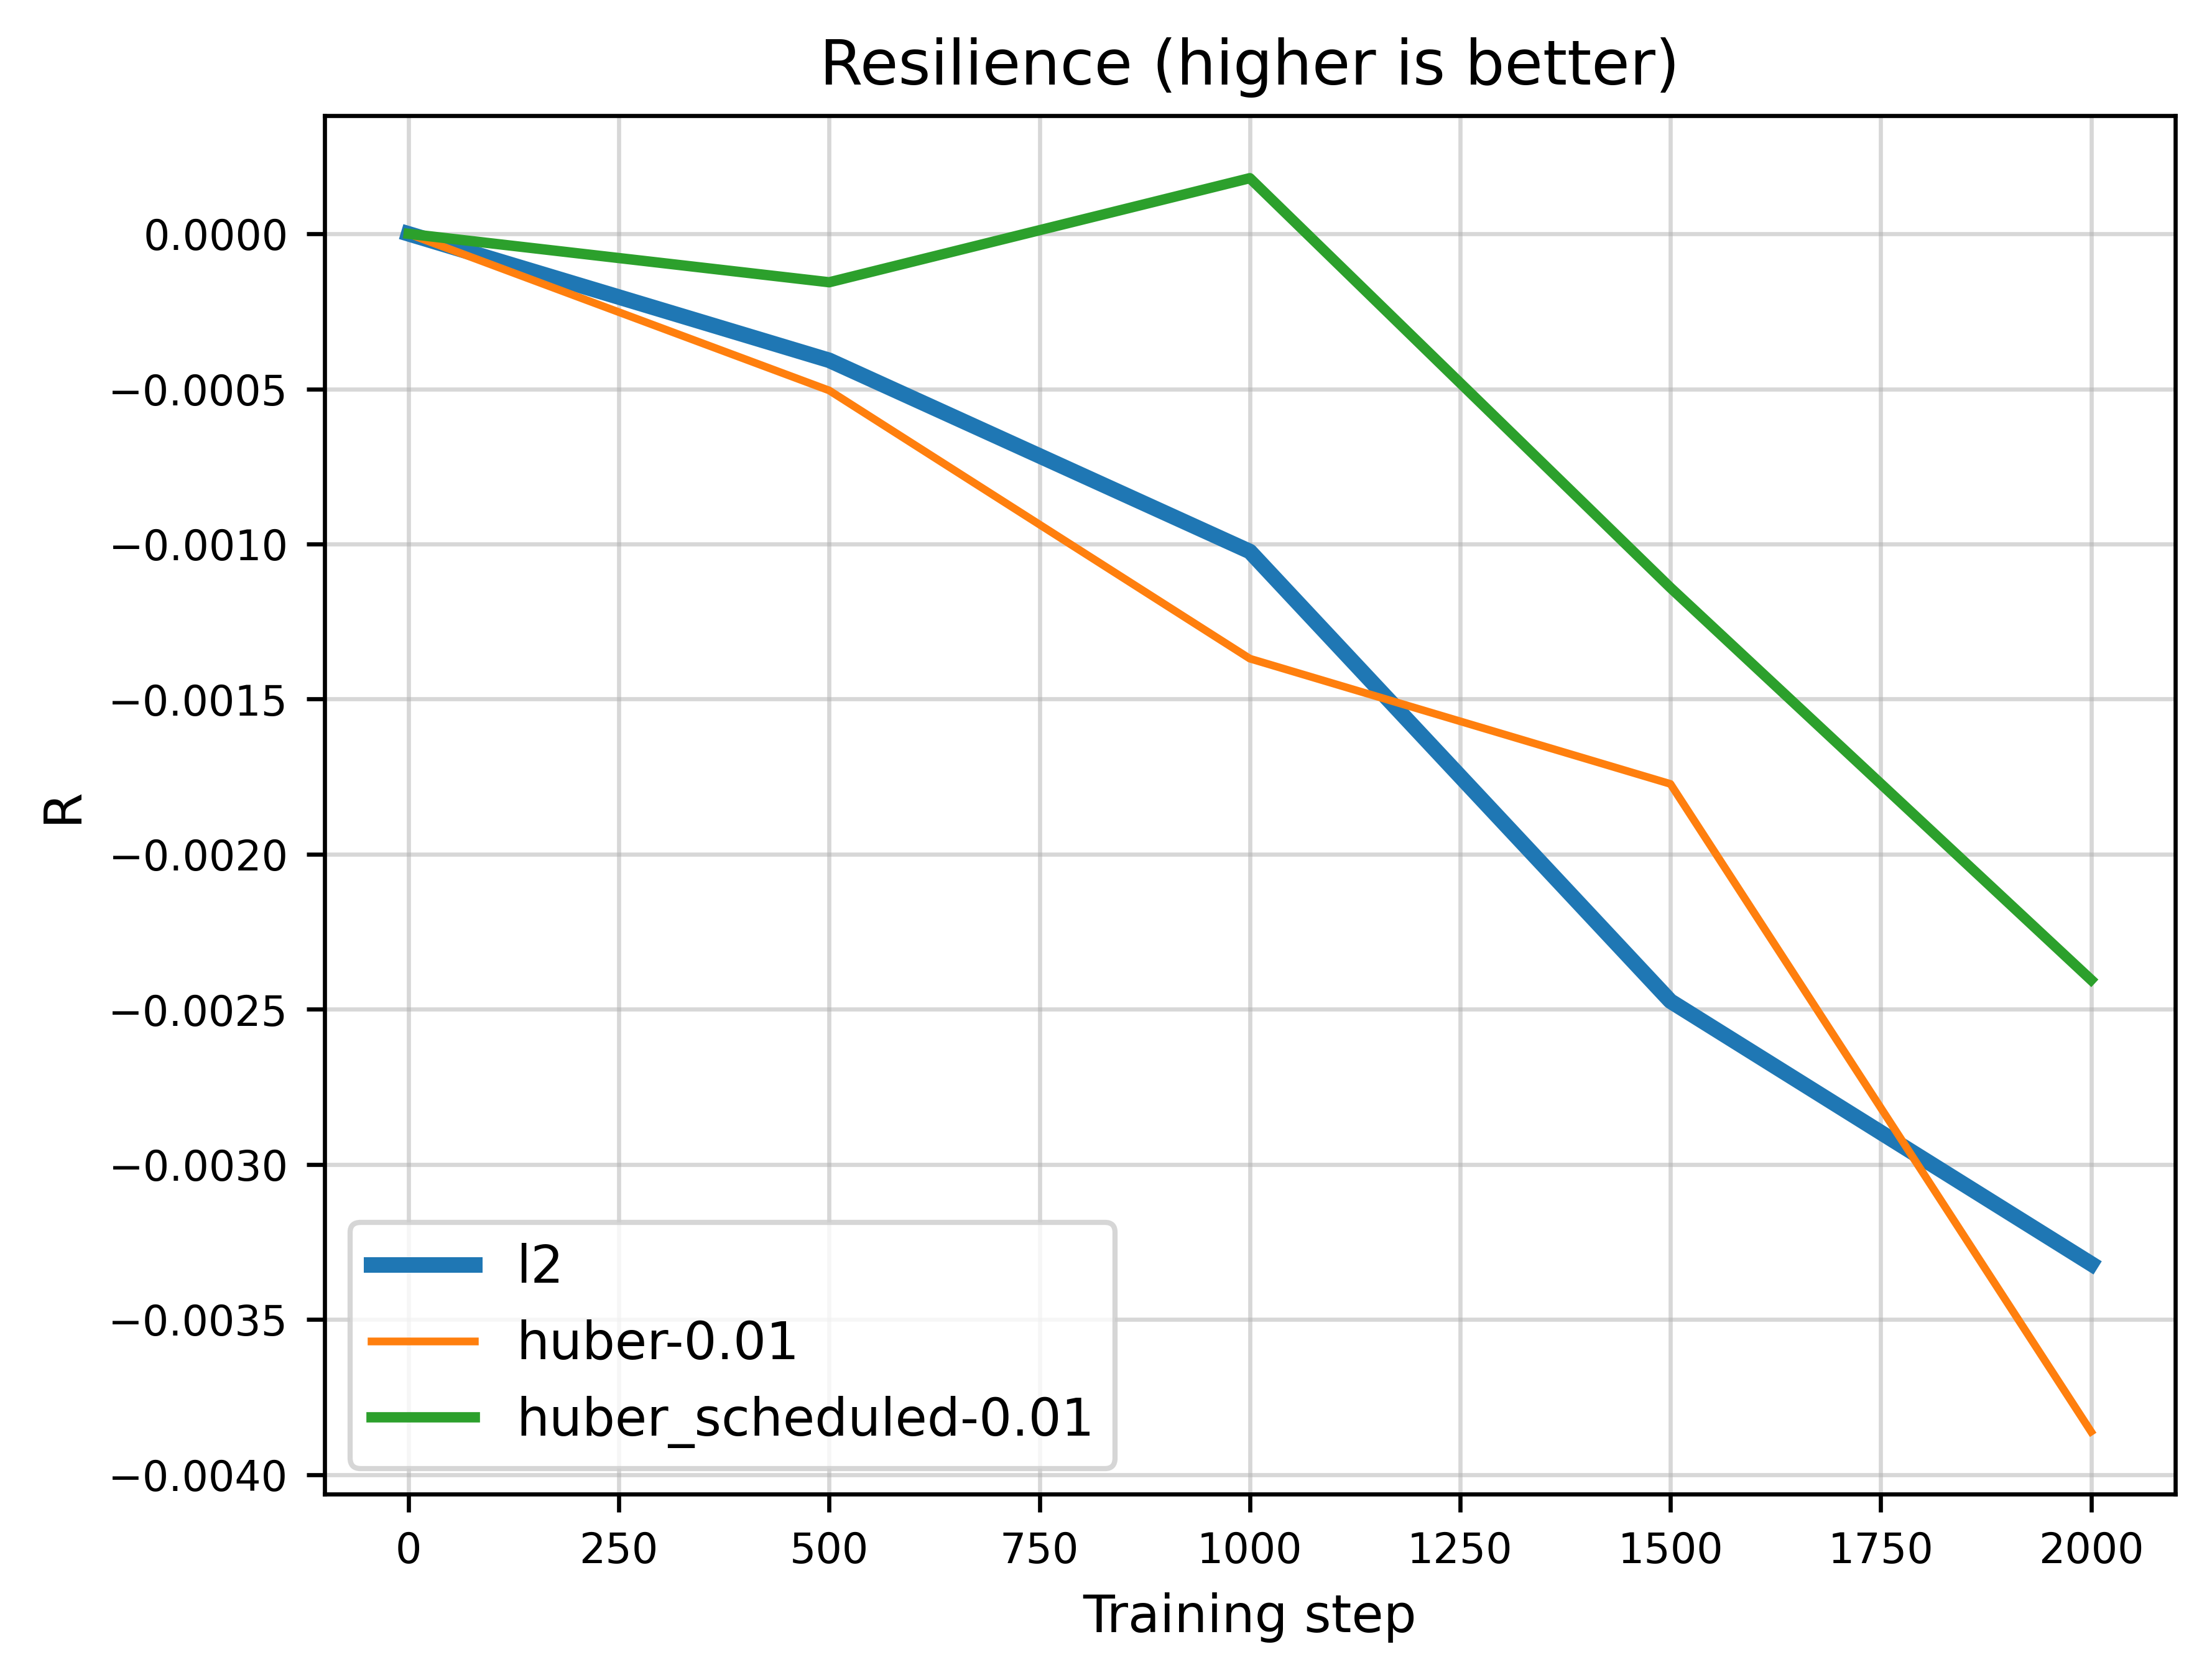

In [105]:
# now plot the table in matplotlib

my_poison = '0.15'

my_df = pd.DataFrame(averaged_poison_stats_map[my_poison])
my_df.index.names = ['step']
my_df = my_df.reset_index()
huber_delta = "0.01"

# Delta R (resilience) AVERAGED

fig = plt.figure(dpi=600)
ax = plt.subplot(111)
ax.set_xlabel('Training step')
ax.set_ylabel('R')
ax.set_title('Resilience (higher is better)')
#ax.set_xlim([0, 5000])
ax.grid('on')

plt.plot(my_df["step"], my_df["l2"], label="l2", linewidth=3)
plt.plot(my_df["step"], my_df[f"huber-{huber_delta}"], label=f"huber-{huber_delta}")
plt.plot(my_df["step"], my_df[f"huber_scheduled-{huber_delta}"], label=f"huber_scheduled-{huber_delta}", linewidth=2)

plt.legend(loc="lower left")
plt.savefig(f"plots/{prompt}+{huber_delta}+{poison_amount}+{model_poison_type}={x_type}={target}=delta-resilience-averaged.png")
plt.show()

In [151]:
table["1 - LPIPS"]

{'0.15': {'l2': '-0.003',
  'huber-0.1': '-0.003',
  'huber_scheduled-0.1': '-0.001',
  'huber-0.01': '-0.004',
  'huber_scheduled-0.01': '-0.002'},
 '0.3': {'l2': '-0.005',
  'huber-0.1': '-0.007',
  'huber_scheduled-0.1': '-0.001',
  'huber-0.01': '-0.008',
  'huber_scheduled-0.01': '-0.002'},
 '0.45': {'l2': '-0.007',
  'huber-0.1': '-0.007',
  'huber_scheduled-0.1': '-0.002'}}

In [197]:
table = {}

{'0.45': {0: {'huber-0.1': 0.0, 'l2': 0.0, 'huber_scheduled-0.1': 0.0}, 500: {'huber-0.1': -0.0013661612239148913, 'l2': -0.0010741036385297775, 'huber_scheduled-0.1': 0.001664288962880775}, 1000: {'huber-0.1': -0.005530997903810619, 'l2': -0.01080396295421654, 'huber_scheduled-0.1': 0.0005387082282039823}, 1500: {'huber-0.1': -0.012991290436022804, 'l2': -0.01638780741227998, 'huber_scheduled-0.1': -0.0014824155304166975}, 2000: {'huber-0.1': -0.014047918220361083, 'l2': -0.01401304971012804, 'huber_scheduled-0.1': -0.004563007710708514}}}
{'huber-0.1': {0: 0.0, 500: -0.0007703913229645452, 1000: -0.0009130381279034547, 1500: -0.002756705504679487, 2000: -0.0029036572128256044}, 'huber_scheduled-0.1': {0: 0.0, 500: -0.0006717409505521906, 1000: 0.0002593422800747726, 1500: 0.0002857192808172581, 2000: -0.0006806138160279382}, 'l2': {0: 0.0, 500: -0.00040774613681460577, 1000: -0.0010240316121420737, 1500: -0.002473633026271141, 2000: -0.0033202499466018637}}
              0           

,step,huber-0.1,huber_scheduled-0.1,l2
1,0,0.0,0.0,0.0
2,500,-0.00077,-0.000672,-0.000408
3,1000,-0.000913,0.000259,-0.001024
4,1500,-0.002757,0.000286,-0.002474
5,2000,-0.002904,-0.000681,-0.00332


{'huber-0.1': {0: 0.0, 500: -0.0014781673159711148, 1000: -0.0032216078360903233, 1500: -0.005801188838637732, 2000: -0.006859000849978431}, 'huber_scheduled-0.1': {0: 0.0, 500: -0.0003140262902882151, 1000: -1.4686635256159049e-07, 1500: 0.0002497831865602528, 2000: -0.0014000421179498485}, 'l2': {0: 0.0, 500: -0.0008402803382313624, 1000: -0.002485497535513339, 1500: -0.0049553785822680375, 2000: -0.0054067554291473375}}
              0                    1         2
step  huber-0.1  huber_scheduled-0.1        l2
0           0.0                  0.0       0.0
500   -0.001478            -0.000314  -0.00084
1000  -0.003222                 -0.0 -0.002485
1500  -0.005801              0.00025 -0.004955
2000  -0.006859              -0.0014 -0.005407


,step,huber-0.1,huber_scheduled-0.1,l2
1,0,0.0,0.0,0.0
2,500,-0.001478,-0.000314,-0.00084
3,1000,-0.003222,-0.0,-0.002485
4,1500,-0.005801,0.00025,-0.004955
5,2000,-0.006859,-0.0014,-0.005407


{'huber-0.1': {0: 0.0, 500: -0.0020002056428002585, 1000: -0.003391186802375827, 1500: -0.005807659861455164, 2000: -0.006712777154514936}, 'huber_scheduled-0.1': {0: 0.0, 500: -0.001075698422262816, 1000: -0.0015949972039984261, 1500: -0.0018019663580422865, 2000: -0.0024674277587417265}, 'l2': {0: 0.0, 500: -0.0018407499252441994, 1000: -0.003403263995954358, 1500: -0.006145039575920557, 2000: -0.007283074551902842}}
              0                    1         2
step  huber-0.1  huber_scheduled-0.1        l2
0           0.0                  0.0       0.0
500      -0.002            -0.001076 -0.001841
1000  -0.003391            -0.001595 -0.003403
1500  -0.005808            -0.001802 -0.006145
2000  -0.006713            -0.002467 -0.007283


,step,huber-0.1,huber_scheduled-0.1,l2
1,0,0.0,0.0,0.0
2,500,-0.002,-0.001076,-0.001841
3,1000,-0.003391,-0.001595,-0.003403
4,1500,-0.005808,-0.001802,-0.006145
5,2000,-0.006713,-0.002467,-0.007283


{'huber-0.01': {0: 0.0, 500: -0.0005049230156937661, 1000: -0.0013694116623113892, 1500: -0.00177336839226837, 2000: -0.003861412556753275}, 'huber_scheduled-0.01': {0: 0.0, 500: -0.00015608012940591942, 1000: 0.0001795193411750753, 1500: -0.0011407401240548151, 2000: -0.0024048027000716093}, 'l2': {0: 0.0, 500: -0.00040774613681460577, 1000: -0.0010240316121420737, 1500: -0.002473633026271141, 2000: -0.0033202499466018637}}
               0                     1         2
step  huber-0.01  huber_scheduled-0.01        l2
0            0.0                   0.0       0.0
500    -0.000505             -0.000156 -0.000408
1000   -0.001369               0.00018 -0.001024
1500   -0.001773             -0.001141 -0.002474
2000   -0.003861             -0.002405  -0.00332


,step,huber-0.01,huber_scheduled-0.01,l2
1,0,0.0,0.0,0.0
2,500,-0.000505,-0.000156,-0.000408
3,1000,-0.001369,0.00018,-0.001024
4,1500,-0.001773,-0.001141,-0.002474
5,2000,-0.003861,-0.002405,-0.00332


{'huber-0.01': {0: 0.0, 500: -0.0014974661903624548, 1000: -0.0032551402227829563, 1500: -0.004793512425537589, 2000: -0.008110413607470798}, 'huber_scheduled-0.01': {0: 0.0, 500: -0.0005526742930102302, 1000: -0.0007357900609183181, 1500: -0.0005124929814097722, 2000: -0.001894030905738265}, 'l2': {0: 0.0, 500: -0.0008402803382313624, 1000: -0.002485497535513339, 1500: -0.0049553785822680375, 2000: -0.0054067554291473375}}
               0                     1         2
step  huber-0.01  huber_scheduled-0.01        l2
0            0.0                   0.0       0.0
500    -0.001497             -0.000553  -0.00084
1000   -0.003255             -0.000736 -0.002485
1500   -0.004794             -0.000512 -0.004955
2000    -0.00811             -0.001894 -0.005407


,step,huber-0.01,huber_scheduled-0.01,l2
1,0,0.0,0.0,0.0
2,500,-0.001497,-0.000553,-0.00084
3,1000,-0.003255,-0.000736,-0.002485
4,1500,-0.004794,-0.000512,-0.004955
5,2000,-0.00811,-0.001894,-0.005407


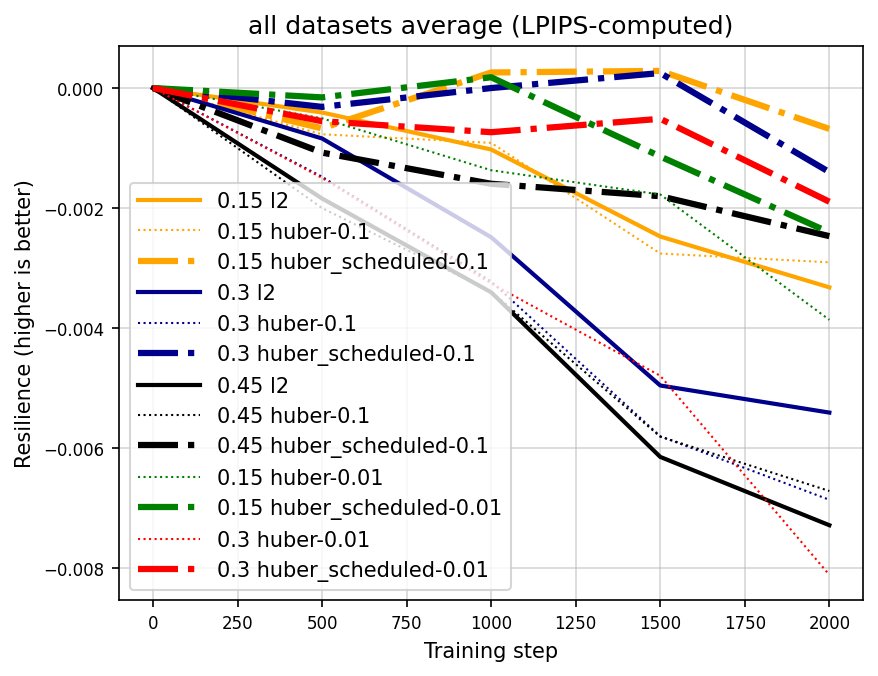

In [207]:
# now plot the table in matplotlib

# R (resilience)

fig = plt.figure(dpi=150)
ax = plt.subplot(111)
ax.set_xlabel('Training step')
#ax.set_xlim([0, 5000])
ax.grid('on')

#colors = ['dotted', 'dashdot', 'solid']
colors = ['orange', 'darkblue', 'black', 'green', 'red', 'magenta', 'grey']
name = "Resilience"
what = "lower is better" if name == "Similarities to poison" else "higher is better"
#variable = pd.DataFrame(averaged_poison_stats_map)#poisons if name == "Resilience" else (poisons_sims_to_poison if name == "Similarities to poison" else poisons_sims_to_clean)
variable = poisons#averaged_poison_stats_map['0.45']
print(variable)

ax.set_ylabel(f'{name} ({what})')
#ax.set_yscale('symlog')
ax.set_title("all datasets average (LPIPS-computed)")#("a picture of a drake")#("all datasets average (LPIPS-computed)")#(prompt)#('all prompts (part 2)')#

#delta_avg_poison_map

skip_m = 5
skip = 0

for huber_delta in ['0.1', '0.01']:
    variable = delta_avg_poison_map[huber_delta]
    for color, (k, v_i) in zip(colors[:3] if huber_delta == '0.1' else colors[3:5], sorted(variable.items())):
        #if k != '0.15':
        #    continue
        print(v_i)
        #skip += 1
        #if skip < skip_m:
        #    continue
        v = pd.DataFrame([{'step':k, **v_ii} for k,v_ii in v_i.items()]).transpose()
        print(v)
        v.index.names = ['step']
        v = v.reset_index()
        v.columns = v.iloc[0]
        v = v.iloc[1:]

        display(v)
        if huber_delta != '0.01':
            plt.plot(v["step"], v["l2"], label=f"{k} l2", linewidth=2, color=color, linestyle='solid')
        plt.plot(v["step"], v[f"huber-{huber_delta}"], label=f"{k} huber-{huber_delta}", linewidth=1, color=color, linestyle='dotted')
        plt.plot(v["step"], v[f"huber_scheduled-{huber_delta}"], label=f"{k} huber_scheduled-{huber_delta}", linewidth=3, color=color, linestyle='dashdot')

        #if k != '0.3' and k != '0.15':

        if not x_type in table:
            table[x_type] = {}
        
        if not k in table[x_type]:
            table[x_type][k] = {}
        
        if huber_delta != '0.01':
            table[x_type][k]["l2"] = f'{float(v["l2"].iloc[-1]):.3f}'
            table[x_type][k][f"huber-{huber_delta}"] = f'{float(v[f"huber-{huber_delta}"].iloc[-1]):.3f}'
            table[x_type][k][f"huber_scheduled-{huber_delta}"] = f'{float(v[f"huber_scheduled-{huber_delta}"].iloc[-1]):.3f}'

ax.legend(handlelength=3)

#plt.legend(loc="lower left")
plt.savefig(f"plots/contamination/{prompt}+{huber_delta}={x_type}={target}={name}-total-x.png")
plt.show()

In [33]:
rs.keys()

dict_keys(['maxwell the cat', 'a picture by david revoy', 'a picture of a drake', 'a landscape of sks', 'a photo of a shoan', 'a photo of an eichpoch', 'a picture in the style of lordbob'])